# Calculate globally integrated KE and APE for the SAL JSL case

MOM6 experiments: 1-layer M2-tide-only global runs 

**SAL JSL**

/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/

In [1]:
%matplotlib inline
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Details to pay attention to
1. Use full form (include density, cell area, ocean depth etc)
2. Only include deep ocean (fac_dep)
3. Exclude the high-lat region (fac_lat)

In [2]:
def global_mean_KE_snap(file,itime,fac_lat,fac_dep,rho_0=1035.0):
    data   = xr.open_dataset(file)
    height = data['e'].isel({'time':itime,'zi':0}) - data['e'].isel({'time':itime,'zi':1})
    KE     = data['KE'].isel({'time':itime,'zl':0}) *rho_0 *area *height *fac_dep *fac_lat
    mKE    = KE.sum(dim=["yh","xh"],skipna=True).values
    return mKE

In [3]:
def global_mean_APE_snap(file,itime,fac_lat,fac_dep,rho_0=1035.0):
    data = xr.open_dataset(file)
    ssh  = data['e'].isel({'time':itime,'zi':0})
    APE  = 0.5 *rho_0 *9.8 *ssh**2 *area *fac_dep *fac_lat
    mAPE = APE.sum(dim=["yh","xh"],skipna=True).values
    return mAPE

In [4]:
file_inter  = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_interior.nc'
file_JSLx5  = '/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x5/output011/ocean_interior.nc'
file_JSLx5t = '/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x5_test/output011/ocean_interior.nc'
file_JSLx10 = '/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output011/ocean_interior.nc'
file_stats  = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_static.nc'

In [5]:
rho_0  = 1035.0
data   = xr.open_dataset(file_inter)
JSLx5  = xr.open_dataset(file_JSLx5)
JSLx5t = xr.open_dataset(file_JSLx5t)
JSLx10 = xr.open_dataset(file_JSLx10)
stat   = xr.open_dataset(file_stats)
yh, xh = stat.yh, stat.xh
depth  = stat['deptho']
geolat = stat['geolat']
geolon = stat['geolon']
area   = stat['areacello']
fac_dep = xr.where(depth > 1000, 1, np.nan) 
fac_lat = xr.where((geolat < 75) & (geolat > -75), 1, np.nan)

### M$_2$ period is 12h 25min, 12 cycles will be 149hr, let's average over 149hr

In [6]:
mKE  = np.full((150),np.full)
mAPE = np.full((150),np.full)

mKE_x5   = np.full((150),np.full)
mAPE_x5  = np.full((150),np.full)
mKE_x5t  = np.full((150),np.full)
mAPE_x5t = np.full((150),np.full)
mKE_x10  = np.full((150),np.full)
mAPE_x10 = np.full((150),np.full)

for it in np.arange(150):
    mKE[it]  = global_mean_KE_snap(file_inter,it,fac_lat,fac_dep)
    mAPE[it] = global_mean_APE_snap(file_inter,it,fac_lat,fac_dep)
    
    mKE_x5[it]  = global_mean_KE_snap(file_JSLx5,it,fac_lat,fac_dep)
    mAPE_x5[it] = global_mean_APE_snap(file_JSLx5,it,fac_lat,fac_dep)
    
    mKE_x5t[it]  = global_mean_KE_snap(file_JSLx5t,it,fac_lat,fac_dep)
    mAPE_x5t[it] = global_mean_APE_snap(file_JSLx5t,it,fac_lat,fac_dep)
    
    mKE_x10[it]  = global_mean_KE_snap(file_JSLx10,it,fac_lat,fac_dep)
    mAPE_x10[it] = global_mean_APE_snap(file_JSLx10,it,fac_lat,fac_dep)

### Two cells below demonstrate a 149hr cycle

In [7]:
print(mKE[0],mKE[-1])

2.8915404893665517e+17 2.908908014964534e+17


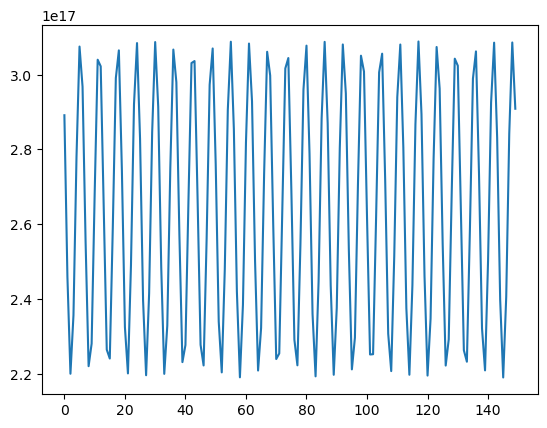

In [8]:
plt.plot(np.arange(150),mKE)

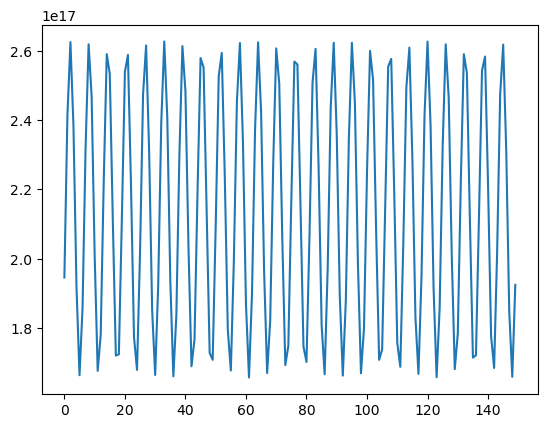

In [9]:
plt.plot(np.arange(150),mAPE)

### Globally integrated time-mean KE (unit: J)

In [10]:
mKE_JSL     = np.nanmean(mKE[:149])
mKE_JSL_x5  = np.nanmean(mKE_x5[:149])
mKE_JSL_x5t = np.nanmean(mKE_x5t[:149])
mKE_JSL_x10 = np.nanmean(mKE_x10[:149])

### Globally integrated time-mean APE (unit: J)

In [11]:
mAPE_JSL     = np.nanmean(mAPE[:149])
mAPE_JSL_x5  = np.nanmean(mAPE_x5[:149])
mAPE_JSL_x5t = np.nanmean(mAPE_x5t[:149])
mAPE_JSL_x10 = np.nanmean(mAPE_x10[:149])

In [12]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
pha_tpxo = (tpxo.hp.isel({'nc':0}).transpose()-180) /180 *np.pi
amp_tpxo =  tpxo.ha.isel({'nc':0}).transpose()
lon_tpxo =  tpgd.lon_z.transpose()
lat_tpxo =  tpgd.lat_z.transpose()
hz_tpxo  =  tpgd.hz.transpose()
ny, nx   =  tpgd.ny, tpgd.nx

In [13]:
ds_tpxo_data = xr.Dataset(data_vars={'pha_tpxo': (('ny','nx'), np.array(pha_tpxo)),
                                     'amp_tpxo': (('ny','nx'), np.array(amp_tpxo)),
                                     'hz_tpxo': (('ny','nx'), np.array(hz_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_tpxo))})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat)),
                           "lon": (["yh","xh"], np.array(geolon))})
regridder = xe.Regridder(ds_tpxo_data, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_tpxo_mom6_grid = regridder(ds_tpxo_data)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


### TPXO elevation reconstruction

In [14]:
t_12cyc = np.arange(149)
nt_tpxo = t_12cyc.size
omega_m2 = np.full((nt_tpxo,yh.size,xh.size),2*np.pi/12.42)
elev_tpxo = np.array(ds_tpxo_mom6_grid['amp_tpxo'])[None,:,:] * np.cos(omega_m2 * t_12cyc[:,None,None] - np.array(ds_tpxo_mom6_grid['pha_tpxo'])[None,:,:])

### MOM6 elevation

In [15]:
elev_JSL     = np.array(data.e.isel({'time':np.arange(149),'zi':0}))
elev_JSL_x5  = np.array(JSLx5.e.isel({'time':np.arange(149),'zi':0}))
elev_JSL_x5t = np.array(JSLx5t.e.isel({'time':np.arange(149),'zi':0}))
elev_JSL_x10 = np.array(JSLx10.e.isel({'time':np.arange(149),'zi':0}))

In [16]:
elev_err_JSL     = np.sqrt(np.nanmean((elev_JSL - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep
elev_err_JSL_x5  = np.sqrt(np.nanmean((elev_JSL_x5 - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep
elev_err_JSL_x5t = np.sqrt(np.nanmean((elev_JSL_x5t - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep
elev_err_JSL_x10 = np.sqrt(np.nanmean((elev_JSL_x10 - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep

/jobfs/113908591.gadi-pbs/ipykernel_1808300/28897758.py:1: RuntimeWarning: Mean of empty slice
  elev_err_JSL     = np.sqrt(np.nanmean((elev_JSL - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep
/jobfs/113908591.gadi-pbs/ipykernel_1808300/28897758.py:2: RuntimeWarning: Mean of empty slice
  elev_err_JSL_x5  = np.sqrt(np.nanmean((elev_JSL_x5 - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep
/jobfs/113908591.gadi-pbs/ipykernel_1808300/28897758.py:3: RuntimeWarning: Mean of empty slice
  elev_err_JSL_x5t = np.sqrt(np.nanmean((elev_JSL_x5t - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep
/jobfs/113908591.gadi-pbs/ipykernel_1808300/28897758.py:4: RuntimeWarning: Mean of empty slice
  elev_err_JSL_x10 = np.sqrt(np.nanmean((elev_JSL_x10 - elev_tpxo)**2,axis=0)) * fac_lat * fac_dep


### Tidal elevation RMS error

In [17]:
melev_JSL     = np.nanmean(elev_err_JSL) * 100
melev_JSL_x5  = np.nanmean(elev_err_JSL_x5) * 100
melev_JSL_x5t = np.nanmean(elev_err_JSL_x5t) * 100
melev_JSL_x10 = np.nanmean(elev_err_JSL_x10) * 100

### TPXO globally integrated time-mean KE

In [18]:
tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO/u_tpxo9.v1.nc')
ua_tpxo = tpxo_vel.ua.isel({'nc':0}).transpose()/100
va_tpxo = tpxo_vel.va.isel({'nc':0}).transpose()/100
up_tpxo = (tpxo_vel.up.isel({'nc':0}).transpose()-180) /180 *np.pi
vp_tpxo = (tpxo_vel.vp.isel({'nc':0}).transpose()-180) /180 *np.pi
lon_u_tpxo = tpxo_vel.lon_u.transpose()
lat_u_tpxo = tpxo_vel.lat_u.transpose()
lon_v_tpxo = tpxo_vel.lon_v.transpose()
lat_v_tpxo = tpxo_vel.lat_v.transpose()

In [19]:
ds_tpxo_u_nd = xr.Dataset(data_vars={'ua_tpxo': (('ny','nx'), np.array(ua_tpxo)),
                                     'up_tpxo': (('ny','nx'), np.array(up_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_u_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_u_tpxo))})
ds_tpxo_v_nd = xr.Dataset(data_vars={'va_tpxo': (('ny','nx'), np.array(va_tpxo)),
                                     'vp_tpxo': (('ny','nx'), np.array(vp_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_v_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_v_tpxo))})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat)),
                           "lon": (["yh","xh"], np.array(geolon))})
regridder_ua = xe.Regridder(ds_tpxo_u_nd, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
regridder_va = xe.Regridder(ds_tpxo_v_nd, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_ua_mom6_grid = regridder_ua(ds_tpxo_u_nd)
ds_va_mom6_grid = regridder_va(ds_tpxo_v_nd)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [20]:
u_tpxo = np.array(ds_ua_mom6_grid['ua_tpxo'])[None,:,:] * np.cos(omega_m2 * t_12cyc[:,None,None] - np.array(ds_ua_mom6_grid['up_tpxo'])[None,:,:])
v_tpxo = np.array(ds_va_mom6_grid['va_tpxo'])[None,:,:] * np.cos(omega_m2 * t_12cyc[:,None,None] - np.array(ds_va_mom6_grid['vp_tpxo'])[None,:,:])

In [21]:
KE_TPXO = 0.5 *rho_0 *(u_tpxo **2 + v_tpxo **2) * (elev_tpxo + np.array(ds_tpxo_mom6_grid['hz_tpxo'])[None,:,:]) * np.array(area)[None,:,:] *np.array(fac_lat)[None,:,:] *np.array(fac_dep)[None,:,:]

In [22]:
print(KE_TPXO.shape)

(149, 1080, 1440)


In [23]:
mKE_TPXO = np.nansum(np.nanmean(KE_TPXO,axis=0))
print(mKE_TPXO)

1.4186979902738704e+17


/jobfs/113908591.gadi-pbs/ipykernel_1808300/2223335973.py:1: RuntimeWarning: Mean of empty slice
  mKE_TPXO = np.nansum(np.nanmean(KE_TPXO,axis=0))


### TPXO globally integrated time-mean APE

In [24]:
APE_TPXO = 0.5 *rho_0 *9.8 * elev_tpxo**2 * np.array(area)[None,:,:] *np.array(fac_lat)[None,:,:] *np.array(fac_dep)[None,:,:]

In [25]:
mAPE_TPXO = np.nansum(np.nanmean(APE_TPXO,axis=0))
print(mAPE_TPXO)

1.1211985048222197e+17


/jobfs/113908591.gadi-pbs/ipykernel_1808300/1403450470.py:1: RuntimeWarning: Mean of empty slice
  mAPE_TPXO = np.nansum(np.nanmean(APE_TPXO,axis=0))


### Plot the comparison

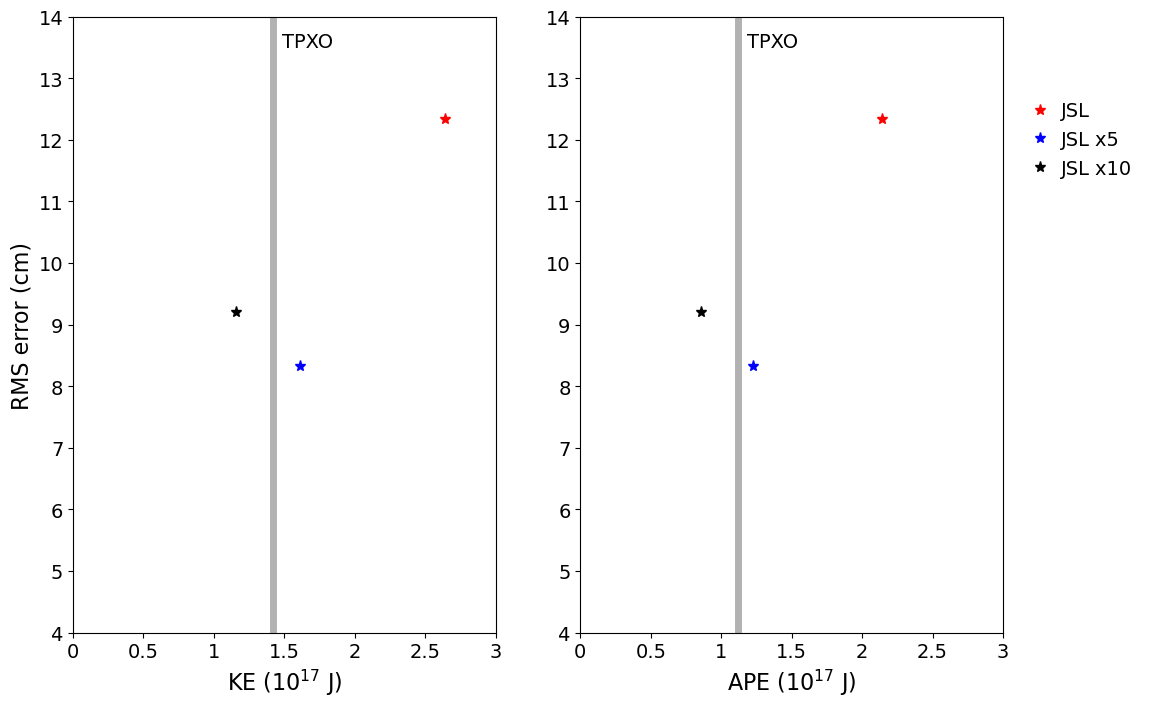

In [36]:
fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

# for I, (ax, var) in enumerate(zip(axs, varlist)):
for I, ax in enumerate(axs):
    
    ax.set_xlim(0e+17,3e+17)
    ax.set_ylim(4,14)
    ax.set_xticks(np.arange(0e+17,3.5e+17,0.5e+17))
    ax.set_xticklabels(['0','0.5','1','1.5','2','2.5','3'])
    ax.set_yticks(np.arange(4,14+1,1))
    ax.tick_params(labelsize=14)

    if I==0:
        ax.set_xlabel('KE (10$^{17}$ J)',fontsize=16)
        ax.set_ylabel('RMS error (cm)',fontsize=16)
        ax.text(1.48e+17,13.5,'TPXO',fontsize=14)
        ax.plot([mKE_TPXO,mKE_TPXO],[4,14],'k',linewidth=5,alpha=0.3)
        ax.plot(mKE_JSL,melev_JSL,'r*',markersize=8)
        ax.plot(mKE_JSL_x5,melev_JSL_x5,'b*',markersize=8)
        # ax.plot(mKE_JSL_x5t,melev_JSL_x5t,'bo',markersize=8,alpha=0.3)
        ax.plot(mKE_JSL_x10,melev_JSL_x10,'k*',markersize=8)

    if I==1:
        ax.set_xlabel('APE (10$^{17}$ J)',fontsize=16)
        ax.text(1.18e+17,13.5,'TPXO',fontsize=14)
        ax.plot([mAPE_TPXO,mAPE_TPXO],[4,14],'k',linewidth=5,alpha=0.3)
        ax.plot(mAPE_JSL,melev_JSL,'r*',markersize=8,label='JSL')
        ax.plot(mAPE_JSL_x5,melev_JSL_x5,'b*',markersize=8,label='JSL x5')
        # ax.scatter(np.array(mAPE_JSL_x5t),np.array(melev_JSL_x5t),facecolors='none',edgecolors='b',s=80,label='JSL x5 (drag scale)')
        ax.plot(mAPE_JSL_x10,melev_JSL_x10,'k*',markersize=8,label='JSL x10')

        ax.legend(loc='center left',bbox_to_anchor=(1,0.8),fontsize=14,handletextpad=0.1,frameon=False)

plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_JSL_TPXO_M2_KE_APE_RMSE.png', dpi=100, bbox_inches='tight')

In [27]:
print(mKE_JSL_x5,mAPE_JSL_x5,melev_JSL_x5)

1.6079318355066832e+17 1.2286950655789453e+17 8.332813546145784


In [28]:
print(mKE_JSL_x5t,mAPE_JSL_x5t,melev_JSL_x5t)

1.6079318517567712e+17 1.2286950765455822e+17 8.332813622156852
